# Project: Solar Power Generation Data

# Introduction
This data has been gathered at two solar power plants in India over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

## Contributions

Initial draft:

- Andreas
    - Data Exploration
    - Imputation
    - Video presentation
    - Pipeline function (Linear pipeline) # TODO add later
    - Resampling
    - .... 
- Brage
    - Cross Validation
    - Common sense baseline
    - ...
- Kathir
    - Arima
    - Data Exploration
    - Data Visualization
    - ....
- Subhashree
    - Data Exploration and initial analysis
    - Data Visualization
    - Linear Regression
    - Random Forest Regressor
    - Initial Scoring and model evaluation metrics
    - PowerPoint Slides
- Yohannes
    - Git
    - Common Sense Baseline
    - Cross Validation
    - Data Visualization
    - Combining the individual notebooks


## Data Exploration
our dataset consist of 4 files 2 for each plant
- power generation data
- weather sensor data

### The power generations data consists of 7 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | DC_POWER | AC_POWER | DAILY_YIELD | TOTAL_YIELD |
| --------- | -------- | ---------- | -------- | -------- | ----------- | ----------- |
| Date and time for each observation <br/>(Plant 1: %d-%m-%Y %H:%M:%S, Plant 2: %Y-%m-%d %H:%M:%S).<br/>Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Source key in this file stands for the inverter id. | Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Daily yield is a cumulative sum of power generated on that day till that point in time. | This is the total yield for the inverter till that point in time. |

### The weather data consists of 6 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | AMBIENT_TEMPERATURE | MODULE_TEMPERATURE | IRRADIATION |
| --------- | -------- | ---------- | -------- | -------- | ----------- |
| Date and time for each observation <br/>(Both: %Y-%m-%d %H:%M:%S). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. | This is the ambient temperature at the plant. | There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. | Amount of irradiation for the 15 minute interval. Solar irradiation is the quantity that measures the energy per unit area of ​​incident solar radiation on a surface - the power received during a time (J/m2 or Wh/m2 )  |

Data is gathered every 15 minutes for 34 days.

Expecting 3264 samples per sampling point:

24 hours x 4 times per hour x 34 days = 3264 samples

## Environment Setup

In [49]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd
import datetime as dt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from scipy import stats

## Extract the data

we assume data files are in the same directory as the notebook.
The data can be accessed at <https://www.kaggle.com/anikannal/solar-power-generation-data/download>

In [6]:
plant_1_gen = pd.read_csv("Plant_1_Generation_data.csv")
plant_2_gen = pd.read_csv("Plant_2_Generation_data.csv")
plant_1_wea = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
plant_2_wea = pd.read_csv("Plant_2_Weather_Sensor_data.csv")

In [7]:
print("Plant 1 has",plant_1_gen['SOURCE_KEY'].nunique(),"sensors")
print("Plant 2 has",plant_2_gen['SOURCE_KEY'].nunique(),"sensors")

Plant 1 has 22 sensors
Plant 2 has 22 sensors



### Plant 1

In [8]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [9]:
plant1_wea = plant_1_wea.isnull().sum()
print(plant1_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


Both weather and generation data has no null values, however this is time series data so what if there are dicontinuity in the time?

In [10]:
temp_gen1 = plant_1_gen.copy()
temp_gen1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


### Plant 2

In [11]:
plant2_info = plant_2_gen.isnull().sum()
print(plant2_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [12]:
plant2_wea = plant_2_wea.isnull().sum()
print(plant2_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


c:\Users\Yohannes\Documents\School\Master\DAT540_Group_11\venv\lib\site-packages\pandas\core\frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:xlabel='DATE_TIME', ylabel='DATE_TIME'>

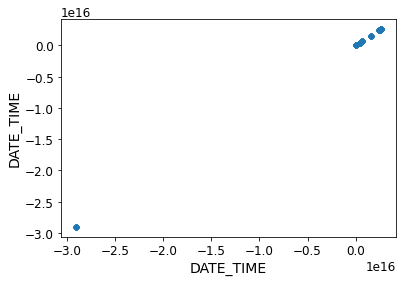

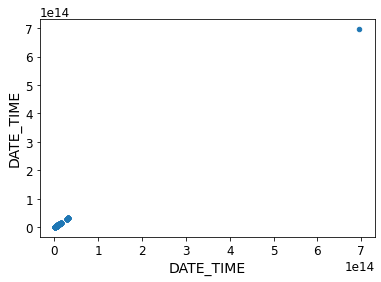

In [13]:
#Data for 34 days and continuous dates
numb_daws = pd.to_datetime(plant_1_gen['DATE_TIME']).dt.date.unique()

plant_1_gen['DATE_TIME'] = pd.to_datetime(plant_1_gen['DATE_TIME'])

data = plant_1_gen.groupby(['SOURCE_KEY']).apply(lambda x: x.sort_values(by=['DATE_TIME'], ascending=True))

time_gaps = pd.DataFrame(data.DATE_TIME.iloc[1:].diff())
non_continuous_dates = time_gaps.loc[(time_gaps.DATE_TIME.dt.seconds > 15*60) | (time_gaps.DATE_TIME.dt.seconds < -15*60)]
non_continuous_dates.index.set_names(["SOURCE_KEY", "Index"], inplace=True)

# non_continuous_dates.index.get_level_values(1)

# plot the non-continuous dates to visualize time gaps. Use the multiindex to identify the sensors and the index of the time gaps

# fill NaT values with 15 min timedelta, in non_continuous_dates
non_continuous_dates.fillna(pd.Timedelta(15*60, unit='s'), inplace=True)

time_gaps.plot(x='DATE_TIME', y='DATE_TIME', kind='scatter')
non_continuous_dates.plot(x='DATE_TIME', y='DATE_TIME', kind='scatter')


#### Some inverters have more data points then the others

In [14]:
#Inverterids
print("Plant 1 statistics \n", plant_1_gen.SOURCE_KEY.value_counts())
print("Plant 2 statistics \n", plant_2_gen.SOURCE_KEY.value_counts())

Plant 1 statistics 
 bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64
Plant 2 statistics 
 xoJJ8DcxJEcupym    3259
WcxssY2VbP4hApt    3259
9kRcWv60rDACzjR    3259
vOuJvMaM2sgwLmb    3259
rrq4fwE8jgrTyWY    3259
LYwnQax7tkwH5Cb    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
oZZkBaNadn6DNKz    3259
PeE6FRyGXUgsRhN    3259
81aHJ1q11NBPMrL    3259
V94E5Ben1TlhnDV    3259
oZ35aAeoifZaQzV    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4

## Data visualization

### **Convert datetime column to datetime format**

In [15]:
#Plant 1 weather data
plant_1_wea['DATE_TIME'] = pd.to_datetime(plant_1_wea['DATE_TIME']) 
plant_1_wea['TIME'] = plant_1_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_1_wea['DATE'] = pd.to_datetime(plant_1_wea['DATE_TIME'].dt.date)
print(plant_1_wea['DATE'])

#Plant 2 weather data
plant_2_wea['DATE_TIME'] = pd.to_datetime(plant_2_wea['DATE_TIME']) 
plant_2_wea['TIME'] = plant_2_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_2_wea['DATE'] = pd.to_datetime(plant_2_wea['DATE_TIME'].dt.date)


0      2020-05-15
1      2020-05-15
2      2020-05-15
3      2020-05-15
4      2020-05-15
          ...    
3177   2020-06-17
3178   2020-06-17
3179   2020-06-17
3180   2020-06-17
3181   2020-06-17
Name: DATE, Length: 3182, dtype: datetime64[ns]


### **Analysis of weather dataset for both the plants**

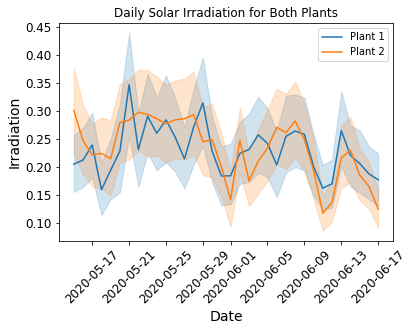

Mean of solar irradition from Plant1 0.22831283006565126
Mean of solar irradition from Plant2 0.23273697972872914


In [16]:
# Comparing both plants
# Daily Irradiation
ambient_compare = sns.lineplot(x='DATE', y='IRRADIATION', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='IRRADIATION', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambient_compare)
plt.ylabel('Irradiation')
plt.xlabel('Date')
plt.title('Daily Solar Irradiation for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of solar Irradiation for both plants are similar
mean_irradiationplant1 = plant_1_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant1', mean_irradiationplant1)
mean_irradiationplant2 =  plant_2_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant2', mean_irradiationplant2)

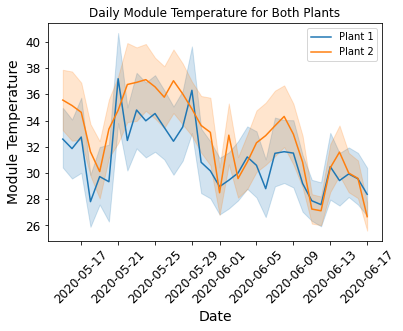

Mean of Module Temperature from Plant1 31.091015378426377
Mean of Module Temperature from Plant2 32.77240792902497


In [17]:
# Daily Module Temperature
modtemp_compare = sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=modtemp_compare)
plt.ylabel('Module Temperature')
plt.xlabel('Date')
plt.title('Daily Module Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of Module Temperature for both plants (Plant 1 is lower then Plant 2)
mean_moduletempplant1 = plant_1_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_moduletempplant1)
mean_moduletempplant2 =  plant_2_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_moduletempplant2)


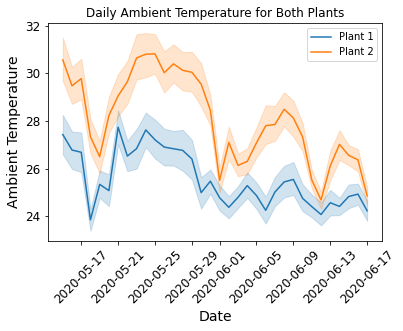

Mean of Ambient Temperature from Plant1 25.53160571756439
Mean of Ambient Temperature from Plant2 28.069399882321143


In [18]:
ambtemp_compare = sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambtemp_compare)
plt.ylabel('Ambient Temperature')
plt.xlabel('Date')
plt.title('Daily Ambient Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()


# The mean of Ambient Temperature for both plants (Plant 1 is lower then Plant 2)
mean_ambienttempplant1 = plant_1_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant1', mean_ambienttempplant1)
mean_ambienttempplant2 =  plant_2_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant2', mean_ambienttempplant2)

#### Observations

1. The mean solar irradiation values for both plants are similar.
2. The mean module temperature of Plant 1 is  lower than Plant 2 most of the time.
3. The mean ambient temperature of Plant 1 is much lower than Plant 2.


## Data cleaning


#### Transform and merge the datasets

##### Drop unwanted columns.

In [19]:
df_weather1 = plant_1_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant1 = plant_1_gen.drop(['PLANT_ID'], axis=1)
df_weather2 = plant_2_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant2 = plant_2_gen.drop(['PLANT_ID'], axis=1)

In [20]:
df_plant1["Human_key"] = df_plant1["SOURCE_KEY"].map({val: f"S{i:02d}" for i, val in enumerate(df_plant1["SOURCE_KEY"].unique())})
df_plant1.sample(20)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Human_key
4336,2020-05-17 05:00:00,ZnxXDlPa8U1GXgE,0.000000,0.000000,0.000000,6535152.000,S07
58853,2020-06-13 06:30:00,z9Y9gH1T5YWrNuG,574.285714,55.585714,17.000000,7216884.000,S18
45863,2020-07-06 03:00:00,ZoEaEvLYb1n2sOq,0.000000,0.000000,0.000000,7265368.000,S08
13777,2020-05-22 07:00:00,z9Y9gH1T5YWrNuG,1584.500000,154.737500,85.625000,7057232.625,S18
48178,2020-08-06 05:15:00,pkci93gMrogZuBj,0.000000,0.000000,0.000000,7346132.000,S13
5757,2020-05-17 21:00:00,zVJPv84UY57bAof,0.000000,0.000000,7480.000000,7136015.000,S20
17105,2020-05-23 23:30:00,zVJPv84UY57bAof,0.000000,0.000000,8544.000000,7180838.000,S20
3844,2020-05-16 23:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,6292.000000,6271605.000,S00
46209,2020-07-06 07:00:00,7JYdWkrLSPkdwr4,1768.285714,173.314286,90.000000,7770547.000,S03
54030,2020-10-06 23:45:00,pkci93gMrogZuBj,0.000000,0.000000,6578.000000,7369294.000,S13


In [21]:
#Formatedattime
df_plant1['DATE_TIME']= pd.to_datetime(df_plant1['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_weather1['DATE_TIME']= pd.to_datetime(df_weather1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
#df_plant1.head()
df_plant2['DATE_TIME']= pd.to_datetime(df_plant2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_weather2['DATE_TIME']= pd.to_datetime(df_weather2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# Andreas cutoff

In [22]:
df_plant_weather1 = df_plant1.merge(df_weather1, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather2 = df_plant2.merge(df_weather2, left_on='DATE_TIME', right_on='DATE_TIME')

print(df_plant_weather1.head())
print(df_plant_weather2.head())

   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

  Human_key  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION      TIME  \
0       S00            25.184316           22.857507          0.0  00:00:00   
1       S01            25.184316           22.857507          0.0  00:00:00   
2       S02            25.184316           22.857507          0.0  00:00:00   
3       S03            25.184316           22.857507          0.0  00:00:00   
4       S04            25.184316           22.857507          0.0  00:00:00   

        DATE  
0 2020-05-15  
1 2020-05-15  
2 202

### Imputation

## Data Analysis

### **Data Correlation Analysis**


Observations:
1. High correlation between DC Power and AC power generation
2. High correlation between DC Power and IRRADIATION
3. Strong correlation between DC Power, AC Power and Module Temperature and Ambient Temperature

In [23]:
corr_matrix = df_plant_weather1.corr()

corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.991305
MODULE_TEMPERATURE     0.954692
AMBIENT_TEMPERATURE    0.703796
DAILY_YIELD            0.076710
TOTAL_YIELD            0.004055
Name: DC_POWER, dtype: float64

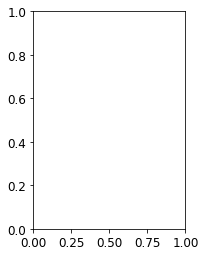

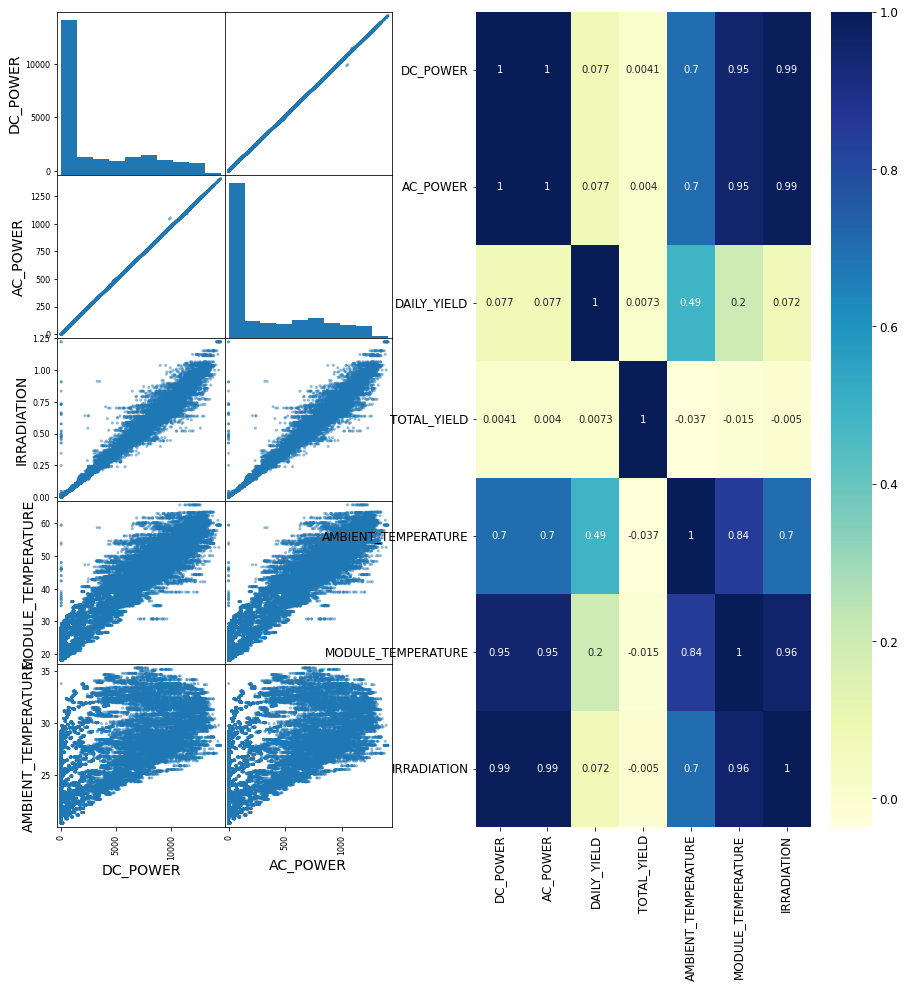

In [24]:
attributes = ["DC_POWER", "AC_POWER", "IRRADIATION",
              "MODULE_TEMPERATURE","AMBIENT_TEMPERATURE"]

plt.subplot(1, 2, 1)
scatter_plot = scatter_matrix(df_plant_weather1[attributes], figsize=(15, 15))

plt.subplot(1, 2, 2)
fig_corr = sns.heatmap(corr_matrix,cmap="YlGnBu", annot=True) # TODO - subplot + margin

**Analysis of DC power generated from each Source Keys.**
1. TheDistribution DC power generation plot shows multiple occasion where power generated was zero during daytime.
2.  plot of solar irradiation exhibits that the solar radiation never dropped to a lower value at day time. 
3. Analysis shows some inverters received no DC power even through there was enough sunlight
4. It could be concluded that the DC power generated and solar irradiation has a linear relationship.

### **Stacked Visualization of Power Generation**

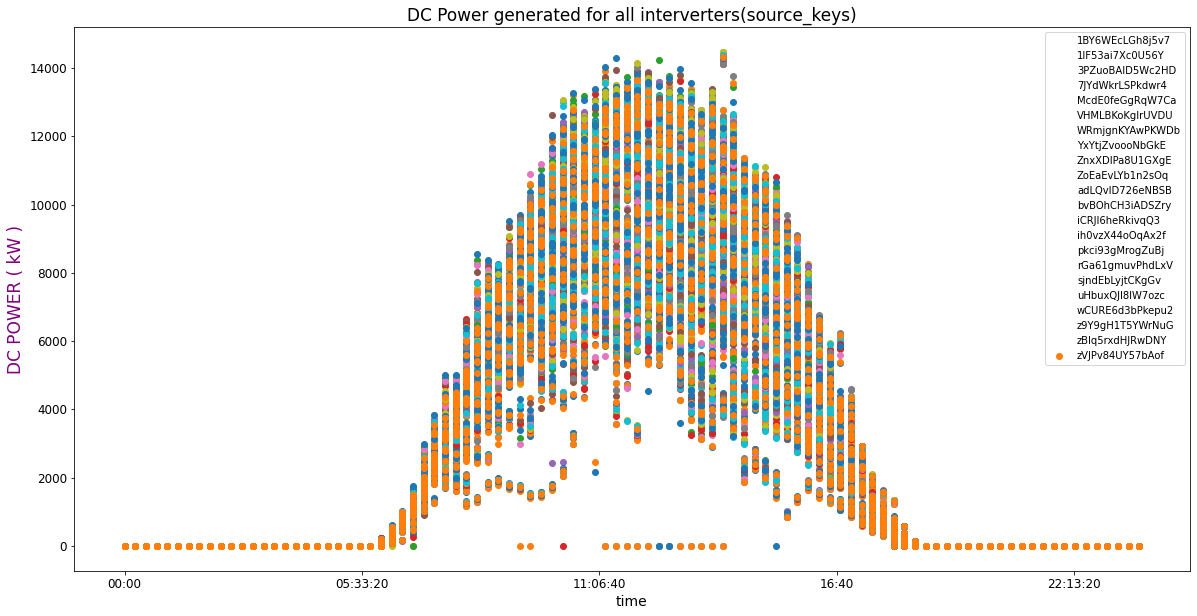

In [25]:
#DC power generated from each source keys
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power generated for all interverters(source_keys)',size=17)
plt.ylabel('DC POWER ( kW )',color='purple',fontsize=17)
plt.show()

                        mean  min          max      median       SOURCE_KEY  \
SOURCE_KEY                                                                    
1BY6WEcLGh8j5v7  2928.590339  0.0  13335.14286  335.625000  1BY6WEcLGh8j5v7   
1IF53ai7Xc0U56Y  3282.160806  0.0  14302.71429  475.464286  1IF53ai7Xc0U56Y   
3PZuoBAID5Wc2HD  3265.846795  0.0  14351.12500  475.214286  3PZuoBAID5Wc2HD   
7JYdWkrLSPkdwr4  3182.008790  0.0  14204.00000  462.500000  7JYdWkrLSPkdwr4   
McdE0feGgRqW7Ca  3269.803912  0.0  14418.42857  499.250000  McdE0feGgRqW7Ca   

                   mean_new  
SOURCE_KEY                   
1BY6WEcLGh8j5v7 -268.939407  
1IF53ai7Xc0U56Y   84.631060  
3PZuoBAID5Wc2HD   68.317049  
7JYdWkrLSPkdwr4  -15.520956  
McdE0feGgRqW7Ca   72.274166  


<AxesSubplot:xlabel='SOURCE_KEY'>

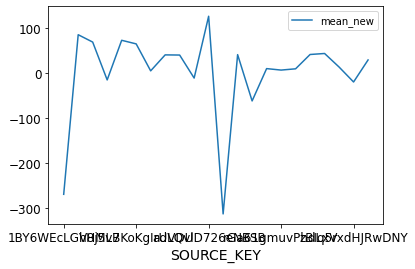

In [26]:
#Inverters with lower performace then rest "1BY6WEcLGh8j5v7", "bvBOhCH3iADSZry"
SOURCE = df_plant_weather1.groupby('SOURCE_KEY').agg({'DC_POWER': ['mean', 'min', 'max','median']})['DC_POWER']
SOURCE["SOURCE_KEY"] = SOURCE.index
mean = SOURCE['mean'].mean()
SOURCE["mean_new"] = SOURCE['mean'] - mean
print(SOURCE.head())

SOURCE.plot(x="SOURCE_KEY", y="mean_new")

## Research

### Select features of interest / Problem Statement

Prediction of power generation using different ML techniques.

### Choose an appropriate ML model based on the dataset and your problem statement.

# Su cutoff

# Yohannes Cutoff

# ML Techniques


### Scoring Function

In [50]:
def scoring(y_test, y_pred):
    R2_train = r2_score(y_test, y_pred)
    mse_train = mean_squared_error(y_test, y_pred)
    rmse_train = np.sqrt(mse_train)
    return(R2_train, mse_train, rmse_train)

In [91]:
# dataframe that saves the different scores from each model
scoring_df = pd.DataFrame(columns=['model', 'Plant', 'R2', 'MSE', 'RMSE'])

In [98]:
def add_model_evaluation(model, plant, r2, mse, rmse):
    if scoring_df.loc[(scoring_df['model'] == model) & (scoring_df['Plant'] == plant)].empty:
        scoring_df.loc[len(scoring_df)] = [model, plant, r2, mse, rmse]
    else:
        scoring_df.loc[(scoring_df['model'] == model) & (scoring_df['Plant'] == plant), 'R2'] = r2
        scoring_df.loc[(scoring_df['model'] == model) & (scoring_df['Plant'] == plant), 'MSE'] = mse
        scoring_df.loc[(scoring_df['model'] == model) & (scoring_df['Plant'] == plant), 'RMSE'] = rmse



### Resampling the data

In [28]:
def make_sample(df,min):
    x = df.copy()
    x.drop("SOURCE_KEY", axis = 1)
    x.set_index("DATE_TIME", inplace = True)
    x.resample(str(min) + " min").mean()
    return  x.fillna(0)

df15 = make_sample(df_plant_weather1, 15)
df30 = make_sample(df_plant_weather1, 30)
df60 = make_sample(df_plant_weather1, 60)
df2h = make_sample(df_plant_weather1, 120)
df4h = make_sample(df_plant_weather1, 240)

In [32]:
def conv_pct(score):
    return round(score*100,0)

def linear_pipeline(df):
    lm = LinearRegression()
    a = df[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features
    b = df['DC_POWER'] # Target
    a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.20, shuffle=False)
    lm.fit(a_train, b_train)
    training_prediction = lm.predict(a_train)
    testing_prediction = lm.predict(a_test)
    train_MAE = metrics.mean_absolute_error(b_train, training_prediction)
    train_MSE = metrics.mean_squared_error(b_train, training_prediction)
    train_RMSE = np.sqrt(metrics.mean_squared_error(b_train, training_prediction))
    test_MAE = metrics.mean_absolute_error(b_test, testing_prediction)
    test_MSE = metrics.mean_squared_error(b_test, testing_prediction)
    test_RMSE = np.sqrt(metrics.mean_squared_error(b_test, testing_prediction))
    train_acc_pct = conv_pct(lm.score(a_train, b_train))
    test_acc_pct = conv_pct(lm.score(a_test, b_test))
    return [training_prediction,testing_prediction]

linear_result15 = linear_pipeline(df15)
linear_result30 = linear_pipeline(df30)
linear_result60 = linear_pipeline(df60)
linear_result2h = linear_pipeline(df2h)


print(linear_pipeline(df15))
print(linear_pipeline(df30))
print(linear_pipeline(df60))
print(linear_pipeline(df2h)) # TODO use scoring function here? or use the scoring in linear_pipeline?

[array([ -97.88813239,  -97.88813239,  -97.88813239, ..., 8016.21675055,
       8016.21675055, 8016.21675055]), array([8016.21675055, 8016.21675055, 8016.21675055, ...,  207.64544365,
        207.64544365,  207.64544365])]
[array([ -97.88813239,  -97.88813239,  -97.88813239, ..., 8016.21675055,
       8016.21675055, 8016.21675055]), array([8016.21675055, 8016.21675055, 8016.21675055, ...,  207.64544365,
        207.64544365,  207.64544365])]
[array([ -97.88813239,  -97.88813239,  -97.88813239, ..., 8016.21675055,
       8016.21675055, 8016.21675055]), array([8016.21675055, 8016.21675055, 8016.21675055, ...,  207.64544365,
        207.64544365,  207.64544365])]
[array([ -97.88813239,  -97.88813239,  -97.88813239, ..., 8016.21675055,
       8016.21675055, 8016.21675055]), array([8016.21675055, 8016.21675055, 8016.21675055, ...,  207.64544365,
        207.64544365,  207.64544365])]


Linear Regression
From the data analysis and corerelation analsysis it was inferred that there is a linear relation between the DC power generated andthe solar irradiation. This relation can be modeled using a simple linear relationship as below,
𝑃(𝑡) = 𝑎 + 𝑏 . 𝐸(𝑡) where p(t) denotes the power generated and the E(t) denotes the solar irradiation. So we will run a linear regression model on our datasets.

## Model 1: Linear Regression for Plant 1 dataset

#### Training and Prediction

In [38]:
X1=df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features 
y1=df_plant_weather1['DC_POWER'] # independent var / predictor

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=1, shuffle=False)

print("Shape of each Dataset : ")
print("X Train Shape = ",X1_train.shape)
print("Y Train Shape = ",y1_train.shape)
print("X Test Shape  = ",X1_test.shape)
print("Y Test Shape  = ",y1_test.shape)

Shape of each Dataset : 
X Train Shape =  (36544, 2)
Y Train Shape =  (36544,)
X Test Shape  =  (9136, 2)
Y Test Shape  =  (9136,)


Fit on training data

In [39]:
lm = LinearRegression()
lm.fit(X1_train, y1_train)
lm.intercept_, lm.coef_

(600.6665002867076, array([-386.64861711,  395.44672194]))

In [40]:
print ('Plant 1 linear regression cofficients are:', X1.columns, lm.coef_ )
print('Plant 1 intercept', lm.intercept_)

Plant 1 linear regression cofficients are: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object') [-386.64861711  395.44672194]
Plant 1 intercept 600.6665002867076


Prediction from model

In [45]:
Y1_pred_test = lm.predict(X1_test)
print ('Prediction Train dataset', Y1_pred_test)

Prediction Train dataset [8016.21675055 8016.21675055 8016.21675055 ...  207.64544365  207.64544365
  207.64544365]


Actual Solar Output Values vs Predicted Values for Plant 1 using Linear Regression (This also includes faulty days dataset)

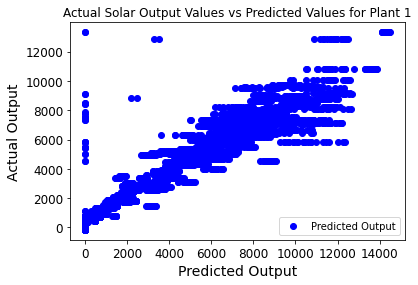

In [69]:
plt.scatter(y1_test, Y1_pred_test,color="b", label="Predicted Output")
# plt.scatter(y1_test, , label="Measured Output") # TODO - add measured output
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')
plt.show()

#### Model Evaluation - (Linear Regression) for Plant 1

In [59]:
train_score_1 = lm.score(X1_train, y1_train)
test_score_1 = lm.score(X1_test, y1_test)

print("Model 1 Plant 1 accuracy score: \n")
print("Train Score = ",train_score_1 * 100,"%")
print("Test Score  = ",test_score_1 * 100, "%")

Model 1 Plant 1 accuracy score: 

Train Score =  95.17032211193732 %
Test Score  =  91.79810639060516 %


In [100]:
r2, mse, rmse = scoring(y1_test, Y1_pred_test)
add_model_evaluation("Linear Regression", "Plant 1", r2, mse, rmse)

print("Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)")
print('R2: ', r2)
print('MSE: ',mse)
print('RMSE: {}'.format(rmse))

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)
R2:  0.9179810639060515
MSE:  1035370.7034047786
RMSE: 1017.531671941851


## Model 1 : Linear Regression for Plant 2 dataset

#### Training and Prediction

In [70]:
X12=df_plant_weather2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION']] # Features 
y12=df_plant_weather2['DC_POWER'] # independent var / predictor

X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X12_train.shape)
print("Y Train Shape = ",y12_train.shape)
print("X Test Shape  = ",X12_test.shape)
print("Y Test Shape  = ",y12_test.shape)

Shape of each Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


Fit on training data for Plant 2

In [71]:
lm = LinearRegression()
lm.fit(X12_train, y12_train)
lm.intercept_, lm.coef_

(-161.97807253891324, array([  14.58534235,   -7.47880945, 1066.65136632]))

Prediction from model

In [79]:
Prediction_plant2 = lm.predict(X12_test)
Prediction_plant2
Y12_pred_train = lm.predict(X12_train) # TODO - do we need this? is it just used for plotting?
Y12_pred_test = lm.predict(X12_test)



print ('Prediction Train dataset', Y12_pred_train)
print ('Prediction Train dataset', Y12_pred_test)

Prediction Train dataset [737.00239381  14.84125906 889.82726669 ... 913.38997752 447.33428339
 676.18815123]
Prediction Train dataset [682.54993805 500.27198931 741.65474769 ... 696.95868419  39.18080934
  25.96295897]


Actual Solar Output Values vs Predicted Values for Plant 2 using Linear Regression (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

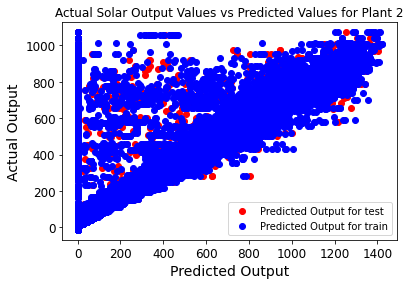

In [78]:
plt.scatter(y12_test, Y12_pred_test, color="r", label="Predicted Output for test")
plt.scatter(y12_train, Y12_pred_train, color="b", label="Predicted Output for train")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 2')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

#### Model Evaluation - (Linear Regression) for Plant 2

Accuracy score for Plant 2 using Linear Regression

In [104]:
train_score_12 = lm.score(X12_train, y12_train)
test_score_12 = lm.score(X12_test, y12_test)

print("Model 1 Plant 2 accuracy score: \n")
print("Train Score = ",round(train_score_12*100,0),"%")
print("Test Score  = ",round(test_score_12*100,0), "%")

Model 1 Plant 2 accuracy score: 

Train Score =  62.0 %
Test Score  =  61.0 %


In [105]:
r2, mse, rmse = scoring(y12_test, Y12_pred_test)
add_model_evaluation("Linear Regression", "Plant 2", r2, mse, rmse)

print("Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)")
print('R2: ', r2)
print('MSE: ',mse)
print('RMSE: {}'.format(rmse))

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)
R2:  0.6074875487162595
MSE:  54287.53837148809
RMSE: 232.9968634370173


## Model 2: Random Forest for Plant 2 dataset 

#### Training and Prediction

Select columns that will be used to create train and test dataset

In [106]:
model_2 = df_plant_weather2
model_2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,00:00:00,2020-05-15


In [112]:
X2 = model_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']] # Features
y2 = model_2['DC_POWER'] # Target

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.20, random_state=1, shuffle=False) 

print("Shape of each New Dataset : ")
print("X Train Shape = ",X2_train.shape)
print("Y Train Shape = ",y2_train.shape)
print("X Test Shape  = ",X2_test.shape)
print("Y Test Shape  = ",y2_test.shape)

Shape of each New Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [113]:
RF = RandomForestRegressor()
RF.fit(X2_train, y2_train)

RandomForestRegressor()

In [114]:
y2_pred_train = RF.predict(X2_train)
y2_pred_test = RF.predict(X2_test)

Actual Solar Output Values vs Predicted Values for Plant 2 using Random Forest Regresor (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

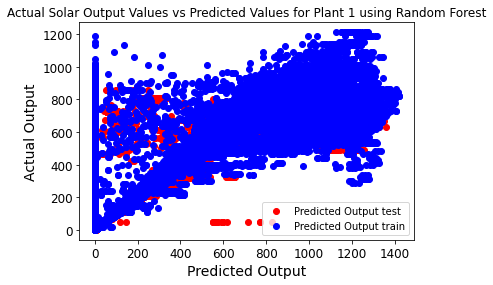

In [115]:
# This also includes faulty days dataset
plt.scatter(y2_test, y2_pred_test,color="r", label="Predicted Output test")
plt.scatter(y2_train, y2_pred_train,color="b", label="Predicted Output train")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1 using Random Forest')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

#### Model Evaluation - (Random Forest Regressor) for Plant 2

Accuracy score for Plant 2 using Random Forest Regressor

In [124]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: \n")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  70.0 %
Test Score  =  68.0 %


In [122]:
r2, mse, rmse = scoring(y2_test, y2_pred_test)
add_model_evaluation("Random Forest Regressor", "Plant 2", r2, mse, rmse)

print("Model Evaluation for Random Forest Regressor (Plant 2)")
print('R2: ', r2)
print('MSE: ',mse)
print('RMSE: {}'.format(rmse))

Model Evaluation for Random Forest Regressor (Plant 2)
R2:  0.681700656363018
MSE:  26674.36694492892
RMSE: 163.3228916745259


#### Feature Scaling

In [126]:
sc = StandardScaler()
X_train = sc.fit_transform(X2_train)
X_test = sc.transform(X2_test)

Running the model after Feature scaling

In [127]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X2_train, y2_train)
y3_pred = regressor.predict(X2_test)

Accuracy score for Model 2 after scaling data

In [128]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: \n")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  70.0 %
Test Score  =  68.0 %


### Cross Validation

In [131]:
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

scores = cross_val_score(lm, X12, y12, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(lm, X1, y1, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(RF, X2_train, y2_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.61 accuracy with a standard deviation of 0.09
0.94 accuracy with a standard deviation of 0.02
0.63 accuracy with a standard deviation of 0.08


The scores turned out to be very low. We figured we couldn't use K-Fold CV on timeseries data.

Hence we chose another Cross Validation method that supports timeseries.

In [134]:
# import timeseriessplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def Cross_Validation(model, X, y, n_splits=10):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    scores = []
    for train_index, test_index in tscv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index] 

        model.fit(X_train, Y_train)
        predict = model.predict(X_test)

        scores.append(model.score(X_test, Y_test))
    
    return (np.mean(scores), np.std(scores))

lm = LinearRegression()
mean_score, std = Cross_Validation(lm, X1, y1)
print("Linear Regression - Plant 1, %0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

lm = LinearRegression()
mean_score, std = Cross_Validation(lm, X12, y12)
print("Linear Regression - Plant 2, %0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

rf = RandomForestRegressor()
mean_score, std = Cross_Validation(rf, X1, y1)
print("Random Forest Regressor - Plant 1, %0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

rf = RandomForestRegressor()
mean_score, std = Cross_Validation(rf, X12, y12)
print("Random Forest Regressor - Plant 2, %0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

    



Linear Regression - Plant 1, 0.94 accuracy with a standard deviation of 0.02
Linear Regression - Plant 2, 0.60 accuracy with a standard deviation of 0.08
Random Forest Regressor - Plant 1, 0.93 accuracy with a standard deviation of 0.02
Random Forest Regressor - Plant 2, 0.63 accuracy with a standard deviation of 0.08


## Model 3: Auto Arima


Tune the parameters of your model. 
Make predictions regarding the future values for some of your chosen variables. 

### Installing all packages and importing files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [135]:
gen_1=pd.read_csv('./Plant_2_Generation_Data.csv')
gen_1.drop('PLANT_ID',1,inplace=True)

gen_2=pd.read_csv('./Plant_1_Generation_Data.csv')
gen_2.drop('PLANT_ID',1,inplace=True)

sens_1= pd.read_csv('./Plant_2_Weather_Sensor_Data.csv')
sens_1.drop('PLANT_ID',1,inplace=True)
#format datetime
gen_1['DATE_TIME']= pd.to_datetime(gen_1['DATE_TIME'],format='%Y-%m-%d %H:%M') #named plant 2 data as gen_1
gen_2['DATE_TIME']= pd.to_datetime(gen_2['DATE_TIME'],format='%d-%m-%Y %H:%M') #named plant 1 data as gen_2
sens_1['DATE_TIME']= pd.to_datetime(sens_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

### Daily Yield & AC-DC power
This plot shows that plant 1 is only outputting barely 10% of expected inverted output. Massive human error involved. Data cannot be used

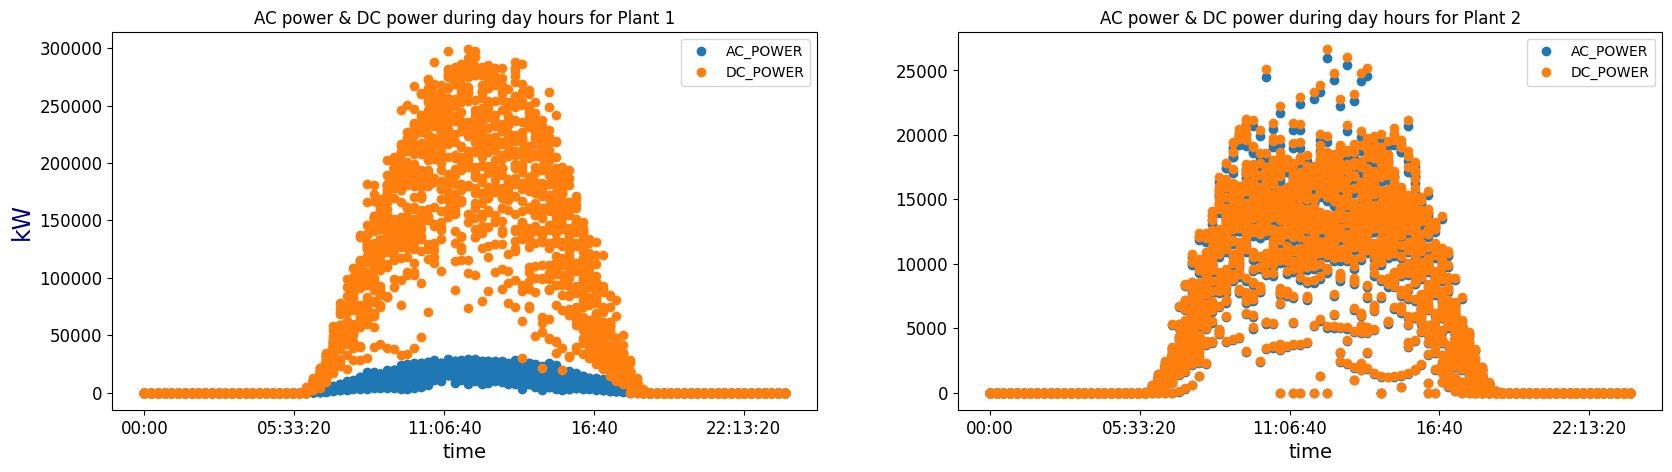

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
3100,2020-05-16 15:00:00,McdE0feGgRqW7Ca,7435.250000,728.012500,5695.000000,7171130.000
3101,2020-05-16 15:00:00,VHMLBKoKgIrUVDU,7342.000000,718.912500,5825.000000,7218491.000
3102,2020-05-16 15:00:00,WRmjgnKYAwPKWDb,7181.375000,703.237500,5746.000000,7040561.000
3103,2020-05-16 15:00:00,YxYtjZvoooNbGkE,7253.375000,710.275000,5601.125000,7191858.125
3104,2020-05-16 15:00:00,ZnxXDlPa8U1GXgE,7420.125000,726.537500,5793.250000,6534269.250
3105,2020-05-16 15:00:00,ZoEaEvLYb1n2sOq,7022.500000,687.712500,5513.250000,7109873.250
3106,2020-05-16 15:00:00,adLQvlD726eNBSB,7206.714286,705.642857,5800.571429,6283538.571
3107,2020-05-16 15:00:00,bvBOhCH3iADSZry,6744.428571,660.585714,5326.714286,6327836.714
3108,2020-05-16 15:00:00,iCRJl6heRkivqQ3,7270.571429,711.942857,5562.000000,7189972.000
3109,2020-05-16 15:00:00,ih0vzX44oOqAx2f,7204.500000,705.500000,5589.250000,6196949.250


In [137]:
df_gen=gen_1.groupby('DATE_TIME').sum().reset_index() #group all items by the increments, which has several inverters. SUm all the inverter values into one. SO you get one value per time step for each collumn
df_gen['time']=df_gen['DATE_TIME'].dt.time #taking the time component from datetime and making a collumn

#Setting up plant 2 dataframe
df_gen2=gen_2.groupby('DATE_TIME').sum().reset_index()
df_gen2['time']=df_gen2['DATE_TIME'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))

# daily yield plot
#df_gen.plot(x='DATE_TIME',y='DAILY_YIELD',color='navy',ax=ax[0])


# AC & DC power plot
df_gen.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[0]) #plant 2 plot
df_gen2.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1]) #plant 1 plot


#ax[0].set_title('Daily yield',)


ax[0].set_title('AC power & DC power during day hours for Plant 2')
ax[1].set_title('AC power & DC power during day hours for Plant 1')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

pd.options.display.max_rows = 4000 #output text size
gen_1[3100:3120] #snapshot of plant 1 to illustrate this dataframe carries several inverters for each time step

### Illustrate that all inverter values have been added to total across each step 
In the above table each inverter is listed individually, on the below table they have all had their values combined for a single output per date-time unit.

In [138]:
df_gen[115:135] 

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,time
115,2020-05-16 07:30:00,54443.982143,5338.832143,3675.803571,1.509028e+08,07:30:00
116,2020-05-16 07:45:00,75347.571428,7404.750000,5239.196429,1.509044e+08,07:45:00
117,2020-05-16 08:00:00,92338.642858,9070.471429,7313.928571,1.509064e+08,08:00:00
118,2020-05-16 08:15:00,105235.303573,10321.041071,9738.428571,1.509089e+08,08:15:00
119,2020-05-16 08:30:00,130559.589285,12793.214286,12581.160714,1.509117e+08,08:30:00
120,2020-05-16 08:45:00,142487.017858,13958.076786,15980.785714,1.509151e+08,08:45:00
121,2020-05-16 09:00:00,140956.303572,13808.626786,19501.750000,1.509186e+08,09:00:00
122,2020-05-16 09:15:00,127605.142857,12505.046429,22719.857143,1.509218e+08,09:15:00
123,2020-05-16 09:30:00,129779.410713,12717.130357,25885.821429,1.509250e+08,09:30:00
124,2020-05-16 09:45:00,161148.232142,15778.142857,29357.875001,1.509285e+08,09:45:00


### Why original DAILY_YIELD and TOTAL_YIELD is wrong

Source Data mentions that DAILY_YIELD is a cumulative sum of power generated on that day, till that point in time. Power is a running rate, it cannot be Cumulative. Therefore we assume that DAILY_YIELD is in KWh (energy). Source Data also mentions TOTAL_YIELD is the total yield for the inverter till that point in time. However, cumulative calculations are not consistent and therefore unusable. 

A snapshot of 3 days will be shown for both. DAILY_YIELD frequenlty dips, even though it has the correct general shape. This cannot be as it is reasonably a calculated value and is CUMULATIVE. The flat lines of TOTAL_YIELD also indicates to clue that it is not a proper cumulative, especially since DAILY_YIELD is regularly producing output. There is also dips here, which are not possible.



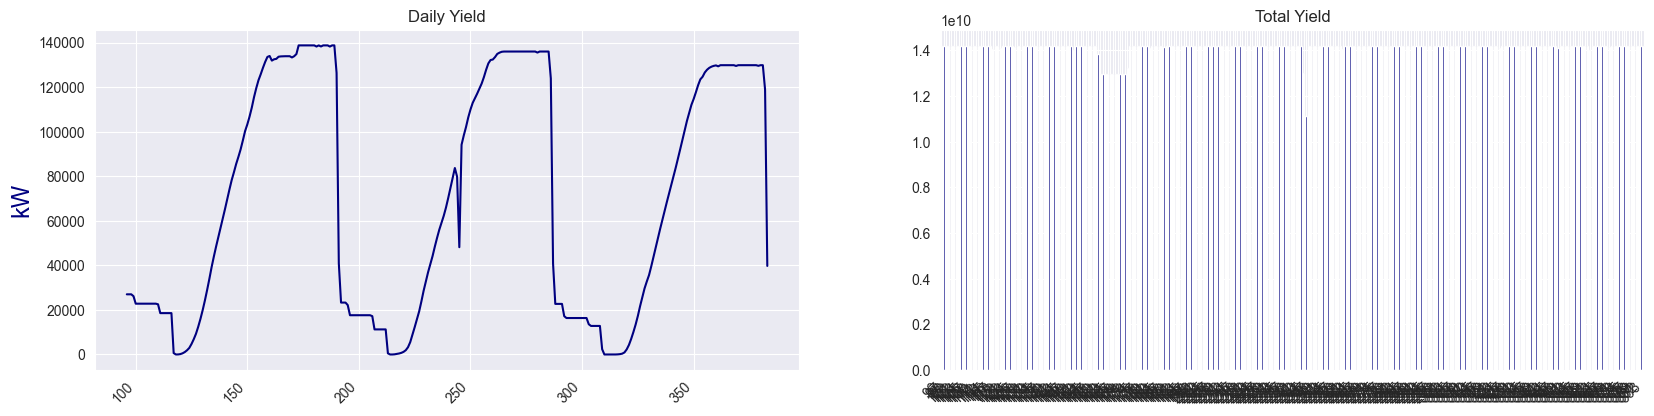

In [ ]:
testDays = df_gen.loc[(df_gen['DATE_TIME'] > '2020-05-16') & (df_gen['DATE_TIME'] <= "2020-05-19")]


fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
testDays['DAILY_YIELD'].plot(ax=ax[0],color='navy') # DAILY_YIELD graph
testDays['TOTAL_YIELD'].plot(ax=ax[1],color='navy') #TOTAL_YIELD graph
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

#testDays

### Creating new and correct DAILY_YIELD and TOTAL_YIELD

In [ ]:
new_df=df_gen.copy()
new_df = new_df.drop(['DAILY_YIELD','TOTAL_YIELD'], 1) #Dropping DAILY_YIELD & TOTAL_YIELD. UNUSABLE

#Converting AC power to KWh entails dividing by 4 since there are 4*15 min in an hour.
new_df["NEW_YIELD"] = (new_df['AC_POWER'] * 0.25) #Energy generation during this step

new_df['date']=new_df['DATE_TIME'].dt.date #taking date component of datetime into a new collumn


new_df["DAILY_YIELD"] = new_df.groupby('date').NEW_YIELD.cumsum() 
new_df["TOTAL_YIELD"] = new_df.NEW_YIELD.cumsum() 

new_df[110:130] #snapshot of new dataframe (single step)


,DATE_TIME,DC_POWER,AC_POWER,time,NEW_YIELD,date,DAILY_YIELD,TOTAL_YIELD
110,2020-05-16 03:45:00,0.000000,0.000000,03:45:00,0.000000,2020-05-16,0.000000,162859.434167
111,2020-05-16 04:00:00,0.000000,0.000000,04:00:00,0.000000,2020-05-16,0.000000,162859.434167
112,2020-05-16 04:15:00,0.000000,0.000000,04:15:00,0.000000,2020-05-16,0.000000,162859.434167
113,2020-05-16 04:30:00,0.000000,0.000000,04:30:00,0.000000,2020-05-16,0.000000,162859.434167
114,2020-05-16 04:45:00,0.000000,0.000000,04:45:00,0.000000,2020-05-16,0.000000,162859.434167
115,2020-05-16 05:00:00,0.000000,0.000000,05:00:00,0.000000,2020-05-16,0.000000,162859.434167
116,2020-05-16 05:15:00,0.000000,0.000000,05:15:00,0.000000,2020-05-16,0.000000,162859.434167
117,2020-05-16 05:30:00,0.000000,0.000000,05:30:00,0.000000,2020-05-16,0.000000,162859.434167
118,2020-05-16 05:45:00,0.000000,0.000000,05:45:00,0.000000,2020-05-16,0.000000,162859.434167
119,2020-05-16 06:00:00,313.557619,302.671905,06:00:00,75.667976,2020-05-16,75.667976,162935.102143


In [ ]:
testDays2 = new_df.loc[(df_gen['DATE_TIME'] > '2020-05-16') & (df_gen['DATE_TIME'] <= "2020-05-19")]


fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
testDays2['DAILY_YIELD'].plot(ax=ax[0],color='navy') # DAILY_YIELD graph
testDays2['TOTAL_YIELD'].plot(ax=ax[1],color='navy') #TOTAL_YIELD graph
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

#new_df.head

NameError: name 'new_df' is not defined

### Compare to Plant 1 YIELD datas
Over the same period

In [ ]:
testDays3 = df_gen2.loc[(df_gen2['DATE_TIME'] > '2020-05-16') & (df_gen2['DATE_TIME'] <= "2020-05-19")]


fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
testDays3['DAILY_YIELD'].plot(ax=ax[0],color='navy') # DAILY_YIELD graph
testDays3['TOTAL_YIELD'].plot(ax=ax[1],color='navy') #TOTAL_YIELD graph
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kWh',color='navy',fontsize=17)
plt.show()


NameError: name 'df_gen2' is not defined

### Daily and Total Yield Plots
Replacing df_gen for easier carrydown

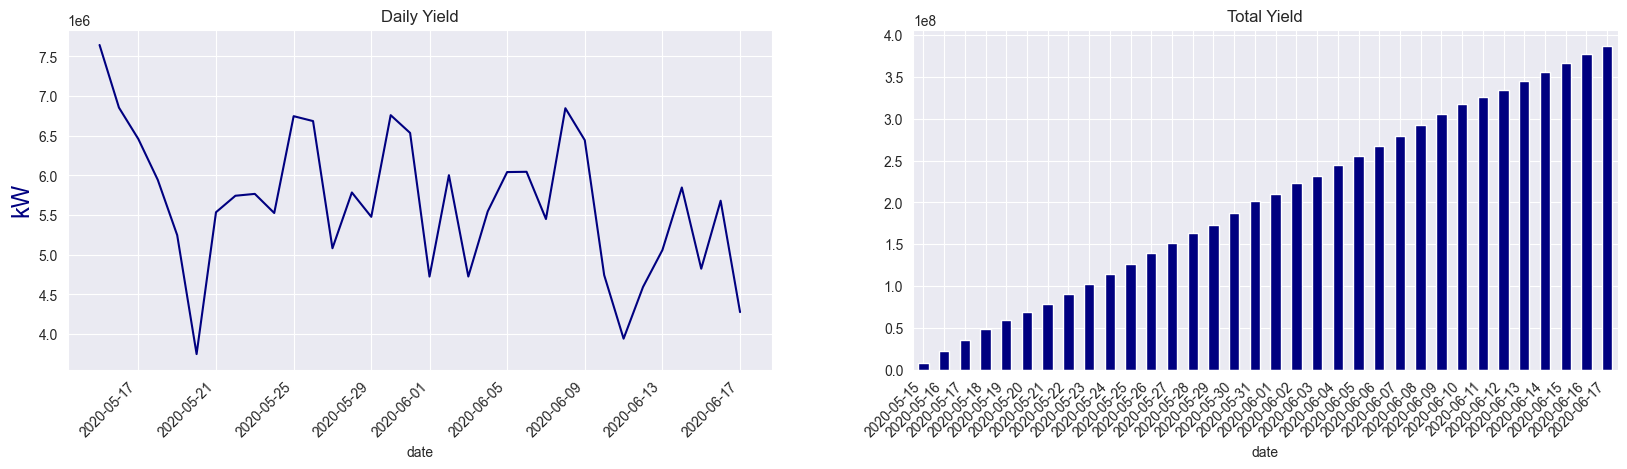

,DC_POWER,AC_POWER,NEW_YIELD,DAILY_YIELD,TOTAL_YIELD
date,,,,,
2020-05-15,666607.630952,651437.736667,162859.434167,7.645248e+06,7.645248e+06
2020-05-16,566839.840000,554253.460476,138563.365119,6.854685e+06,2.248919e+07
2020-05-17,556236.918205,544393.020916,136098.255229,6.457714e+06,3.539430e+07
2020-05-18,530773.677143,519012.565238,129753.141310,5.942708e+06,4.794473e+07
2020-05-19,443495.847015,433554.722647,108388.680662,5.245356e+06,5.913640e+07
2020-05-20,352374.378810,344661.406190,86165.351548,3.744291e+06,6.860793e+07
2020-05-21,494112.260000,483021.364286,120755.341071,5.534586e+06,7.867010e+07
2020-05-22,498711.327619,487411.941136,121852.985284,5.742565e+06,9.047059e+07
2020-05-23,501823.294762,490450.510476,122612.627619,5.766006e+06,1.021919e+08


In [ ]:
df_gen = new_df #replacing df_gen for easier carrydown
daily_gen=df_gen.copy()
daily_gen['date']=daily_gen['DATE_TIME'].dt.date #taking date component of datetime into a new collumn

daily_gen=daily_gen.groupby('date').sum() #summing all the steps in a date so u get one value per date

fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
daily_gen['DAILY_YIELD'].plot(ax=ax[0],color='navy')
daily_gen['TOTAL_YIELD'].plot(kind='bar',ax=ax[1],color='navy')
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kWh',color='navy',fontsize=17)
plt.show()

daily_gen

### Forecast to predict the power generation for next couple of days

We're going to predict exactly the next two days of yield generated by plant_1 raw data, plant_2 corrected data, as well as dc output for both plants.

We will tune, with auto_arima function, a SEASONAL ARIMA(p,d,q) + (P,D,Q,m) model,on the last 4 days(384 observations) to see if our model can capture the last generation trend. 

In [ ]:
from pandas.tseries.offsets import DateOffset
! pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


### Our DATAFRAMES:
#### Generator 1 DAILY_YIELD raw values

Each day has 96 steps (24 hours divided by 15 min). So 288 means 3*96 for a total of 3 days.

In [ ]:
#pred_gen=gen_2.copy()
pred_gen1_DY=gen_2.copy()

pred_gen1_DY=pred_gen1_DY.groupby('DATE_TIME').sum()
pred_gen1_DY=pred_gen1_DY['DAILY_YIELD'][-288:].reset_index()
pred_gen1_DY.set_index('DATE_TIME',inplace=True)
pd.options.display.max_rows = 4000


plt.figure(figsize=(15,5))
plt.plot(pred_gen1_DY,label='Train',color='navy')
plt.title('Last 3 days of Generator 1 DAILY_YIELD ',fontsize=17)
plt.legend()
plt.show()

NameError: name 'gen_2' is not defined

#### Generator 2 DAILY_YIELD fixed (calculated from AC power) values:

In [ ]:
pred_gen2_DY=new_gen1.copy()
pred_gen2_DY=pred_gen2_DY.groupby('DATE_TIME').sum()
pred_gen2_DY=pred_gen2_DY['DAILY_YIELD'][-288:].reset_index()
pred_gen2_DY.set_index('DATE_TIME',inplace=True)
pd.options.display.max_rows = 4000


plt.figure(figsize=(15,5))
plt.plot(pred_gen2_DY,label='Train',color='navy')
plt.title('Last 3 days of Generator 2 DAILY_YIELD',fontsize=17)
plt.legend()
plt.show()

#### Generator 1 DC_OUTPUT values:

In [ ]:
pred_gen1_DC=gen_2.copy()
pred_gen1_DC=pred_gen1_DC.groupby('DATE_TIME').sum()
pred_gen1_DC=pred_gen1_DC['DC_POWER'][-288:].reset_index()
pred_gen1_DC.set_index('DATE_TIME',inplace=True)
pd.options.display.max_rows = 4000


plt.figure(figsize=(15,5))
plt.plot(pred_gen1_DC,label='Train',color='navy')
plt.title('Last 3 days of Generator 1 DC_OUTPUT',fontsize=17)
plt.legend()
plt.show()

#### Generator 2 DC_OUTPUT values:

In [ ]:
pred_gen2_DC=gen_1.copy()
pred_gen2_DC=pred_gen2_DC.groupby('DATE_TIME').sum()
pred_gen2_DC=pred_gen2_DC['DC_POWER'][-288:].reset_index()
pred_gen2_DC.set_index('DATE_TIME',inplace=True)
pd.options.display.max_rows = 4000


plt.figure(figsize=(15,5))
plt.plot(pred_gen2_DC,label='Train',color='navy')
plt.title('Last 3 days of Generator 2 DC_OUTPUT',fontsize=17)
plt.legend()
plt.show()

taken from <https://www.kaggle.com/virosky/how-to-manage-a-solar-power-plant#Task-1:-Can-we-identify-faulty-or-suboptimally-performing-equipment?>


### Testing for Stationarity

We can use the Augmented Dickey-Fuller unit root test.

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying whether to accept the Null Hypothesis H0 (that the time series has a unit root, indicating it is non-stationary) or reject H0 and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

We will do this for all 4 of our dataframes. This will affect the 'd' value when we train the model.

In [ ]:
dataframes = [pred_gen1_DY['DAILY_YIELD'], pred_gen2_DY['DAILY_YIELD'], pred_gen1_DC['DC_POWER'], pred_gen2_DC['DC_POWER']]
dataframe_labels = ['pred_gen1_DY', 'pred_gen2_DY', 'pred_gen1_DC', 'pred_gen2_DC']

for value1, dataframe_labels in zip(dataframes, dataframe_labels):

    result = adfuller(value1)
    print('Augmented Dickey-Fuller Test for ', dataframe_labels)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        
    if result[1] <= 0.05:
        print("Set d to 0.")
    else:
        print("Set d to 1.")
        
    print('\r\r\r\n')

### Step 2: Split into train and test datasets to build the model on the training dataset and forecast using the test dataset.

Reference from the documentation of ARIMAX:

The auto_arima function fits the best ARIMA model to an univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

ARIMA models are made up of three different terms:

p: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.
d: The degree of differencing.
q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

Seasonal ARIMA models have three parameters that heavily resemble our p, d and q parameters:

`P` is  The order of the seasonal component for the auto-regressive (AR) model.

`D` is The integration order of the seasonal process.

`Q` is The order of the seasonal component of the moving average (MA) model.
P and Q and be estimated similarly to p and q via auto_arima, and D can be estimated via a Canova-Hansen test, however m generally requires subject matter knowledge of the data.

Each day we hhas 96 observations at 15 min intervals so `m` = 96 to capture daily trend.
P,D,Q paramaters in the seasonal component set to default 1 for speed and simplicity. 

### pred_gen1_DY Forecasts
Setting up dataframe

In [ ]:
#train=pred_gen[:192]
#test=pred_gen[-98:]
#dataframes = [pred_gen1_DY, pred_gen2_DY, pred_gen1_DC, pred_gen2_DC]
#dataframe_labels = ['pred_gen1_DY', 'pred_gen2_DY', 'pred_gen1_DC', 'pred_gen2_DC']
#trainingData = []
#testData = []

#for dataframe, dataframe_labels in zip(dataframes, dataframe_labels):

dataframe = pred_gen1_DY
dataframe_labels = "pred_gen1_DY"


train = dataframe[:192]
test = dataframe[-96:]


plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of ' + dataframe_labels,fontsize=17)
plt.legend()
plt.show()

#train

#### Training and Forecasting

In [ ]:
#for data1, data2, labels in zip(trainingData, testData, dataframe_labels):
#Didn't use loops because it caused issues with labels when attempted.

arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=12,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set ' + dataframe_labels,size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)



f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(dataframe,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)
plt.show()
print('-'*15)

arima_model.summary()



### Baseline vs Prediction metrics pred_gen1_DY

### Baseline
Setting up common-sense baseline for DAILY_YIELD

In [ ]:
baseline = dataframe.groupby([pd.to_datetime(dataframe.index.hour), pd.to_datetime(dataframe.index.minute)])["DAILY_YIELD"].mean()
baseline_df = pd.DataFrame(baseline)
baseline_df.plot()


In [ ]:
print('Baseline R2 Score: %f' % (r2_score(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'])))
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('Baseline MAE Score: %f' % (mean_absolute_error(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_yield'],test['DAILY_YIELD'],squared=False)))
print('Baseline RMSE Score: %f' % (mean_squared_error(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'],squared=False)))

### pred_gen2_DY Forecasts
Setting up dataframe

In [ ]:
dataframe = pred_gen2_DY
dataframe_labels = "pred_gen2_DY"


train=dataframe[:192]
test=dataframe[-96:]

#trainingData.append(train)
#testData.append(test)

plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of ' + dataframe_labels,fontsize=17)
plt.legend()
plt.show()

Training and Forecasting

In [ ]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=12,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set ' + dataframe_labels,size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(dataframe,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast' + dataframe_labels,size=17)
plt.show()


arima_model.summary()

### Baseline vs Prediction metrics pred_gen2_DY

#### Baseline
Setting up common-sense baseline for DAILY_YIELD

In [ ]:
baseline = dataframe.groupby([pd.to_datetime(dataframe.index.hour), pd.to_datetime(dataframe.index.minute)])["DAILY_YIELD"].mean()
baseline_df = pd.DataFrame(baseline)
baseline_df.plot()

In [ ]:
print('Baseline R2 Score: %f' % (r2_score(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'])))
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['DAILY_YIELD'])))
print('Baseline MAE Score: %f' % (mean_absolute_error(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_yield'],test['DAILY_YIELD'],squared=False)))
print('Baseline RMSE Score: %f' % (mean_squared_error(baseline_df['DAILY_YIELD'], test['DAILY_YIELD'],squared=False)))

### pred_gen1_DC Forecasts
Setting up dataframe

In [ ]:

dataframe = pred_gen1_DC
dataframe_labels = "pred_gen1_DC"

train=dataframe[:192]
test=dataframe[-96:]


plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of ' + dataframe_labels,fontsize=17)
plt.legend()
plt.show()


Training and Forecasting

In [ ]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=12,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set' + dataframe_labels,size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(dataframe,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast' + dataframe_labels,size=17)
plt.show()

arima_model.summary()

### Prediction vs Baeline metrics pred_gen1_DC

Setting up common-sense baseline for DC_POWER

In [ ]:
baseline = dataframe.groupby([pd.to_datetime(dataframe.index.hour), pd.to_datetime(dataframe.index.minute)])["DC_POWER"].mean()
baseline_df_DC = pd.DataFrame(baseline)
baseline_df_DC.plot()

In [ ]:
print('Baseline R2 Score: %f' % (r2_score(baseline_df_DC['DC_POWER'], test['DC_POWER'])))
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['DC_POWER'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['DC_POWER'])))
print('Baseline MAE Score: %f' % (mean_absolute_error(baseline_df_DC['DC_POWER'], test['DC_POWER'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_yield'],test['DC_POWER'],squared=False)))
print('Baseline RMSE Score: %f' % (mean_squared_error(baseline_df_DC['DC_POWER'], test['DC_POWER'],squared=False)))

### pred_gen2_DC Forecasts
Setting up dataframe

In [ ]:

dataframe = pred_gen2_DC
dataframe_labels = "pred_gen2_DC"


train=dataframe[:192]
test=dataframe[-96:]

plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of ' + dataframe_labels,fontsize=17)
plt.legend()
plt.show()


Training and Forecasting

In [ ]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=12,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set' + dataframe_labels,size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(dataframe,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast' + dataframe_labels,size=17)
plt.show()

arima_model.summary()

### Prediction vs Baeline metrics pred_gen2_DC

#### Baseline


Setting up common-sense baseline for DC_POWER

In [ ]:
baseline = dataframe.groupby([pd.to_datetime(dataframe.index.hour), pd.to_datetime(dataframe.index.minute)])["DC_POWER"].mean()
baseline_df_DC = pd.DataFrame(baseline)
baseline_df_DC.plot()

In [ ]:
print('Baseline R2 Score: %f' % (r2_score(baseline_df_DC['DC_POWER'], test['DC_POWER'])))
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['DC_POWER'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['DC_POWER'])))
print('Baseline MAE Score: %f' % (mean_absolute_error(baseline_df_DC['DC_POWER'], test['DC_POWER'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_yield'],test['DC_POWER'],squared=False)))
print('Baseline RMSE Score: %f' % (mean_squared_error(baseline_df_DC['DC_POWER'], test['DC_POWER'],squared=False)))

### Conclusions
 
ARIMAX outperforms common-sense-baseline for DAILY_YIELD (displayed top left) but not DC_POWER (top right).

Our chosen common-sense-baseline is an aggregation of all values for that time-step (15 min), which would produce the most expectant value within 80% accuracy. Pictured at top.

To properly tune ARIMA in-depth knowledge of the model and data is required. We suggest further research can be done to understand this discrepancy in performance among different data types when similar performance is to be expected. 

The much greater degree of variance is one suspected culprit in DC_POWER.

# References